In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import TransformerMixin


import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

seed = 42

train_df = pd.read_csv('../dataset/train_preprocess.csv', encoding='latin-1')
test_df = pd.read_csv('../dataset/test_preprocess.csv', encoding='latin-1')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_df['average_salary'] = (train_df['salary_min'] + train_df['salary_max']) / 2
train_df['salary_ratio'] = train_df['salary_max'] / train_df['salary_min']
train_df['salary_range'] = pd.cut(train_df['salary_ratio'],
                            bins=[-float('inf'), 1.25, 1.5, float('inf')],
                            labels=['Low', 'Medium', 'High'],
                            right=False) # Ensure that the intervals are left-closed
print('Training Data:')
print(train_df['salary_range'].value_counts())


test_df['average_salary'] = (test_df['salary_min'] + test_df['salary_max']) / 2
test_df['salary_ratio'] = test_df['salary_max'] / test_df['salary_min']
test_df['salary_range'] = pd.cut(test_df['salary_ratio'],
                            bins=[-float('inf'), 1.25, 1.5, float('inf')],
                            labels=['Low', 'Medium', 'High'],
                            right=False) # Ensure that the intervals are left-closed
print('Testing Data:')
print(test_df['salary_range'].value_counts())

Training Data:
salary_range
Medium    4818
High      3114
Low       2710
Name: count, dtype: int64
Testing Data:
salary_range
Medium    513
High      366
Low       303
Name: count, dtype: int64


### Text Preprocessing

In [3]:
# For training data
train_df['snippet Total Words'] = train_df['snippet'].apply(lambda x: len(x.split()))
train_df['snippet Total Chars'] = train_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))
train_df['Original snippet'] = train_df['snippet']  # Save a copy of the original text for comparison

train_df['title Total Words'] = train_df['title'].apply(lambda x: len(x.split()))
train_df['title Total Chars'] = train_df['title'].apply(lambda x: sum(len(word) for word in x.split()))
train_df['Original title'] = train_df['title']  # Save a copy of the original text for comparison

# For testing data
test_df['snippet Total Words'] = test_df['snippet'].apply(lambda x: len(x.split()))
test_df['snippet Total Chars'] = test_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))
test_df['Original snippet'] = test_df['snippet']  # Save a copy of the original text for comparison

test_df['title Total Words'] = test_df['title'].apply(lambda x: len(x.split()))
test_df['title Total Chars'] = test_df['title'].apply(lambda x: sum(len(word) for word in x.split()))
test_df['Original title'] = test_df['title']  # Save a copy of the original text for comparison

In [4]:
train_df['snippet'] = train_df['Original snippet']
train_df['title'] = train_df['Original title']

test_df['snippet'] = test_df['Original snippet']
test_df['title'] = test_df['Original title']

# Initialize removal counters
removal_counters = {
    'Removing URLs': {'characters': 0, 'words': 0},
    'Removing Punctuations': {'characters': 0, 'words': 0},
    'Removing Stopwords': {'characters': 0, 'words': 0},
    'Removing Numbers': {'characters': 0, 'words': 0},
    'Removing ASCII that cannot translate': {'characters': 0, 'words': 0},
    'Removing unnecessary whitespace': {'characters': 0, 'words': 0},
    'Stemming': {'characters': 0, 'words': 0}
}

# Function to track removed characters and words
def track_changes(original_text, processed_text, step_name):
    removed_chars = len(original_text) - len(processed_text)
    removed_words = len(original_text.split()) - len(processed_text.split())
    removal_counters[step_name]['characters'] += removed_chars
    removal_counters[step_name]['words'] += removed_words
    return processed_text


# Removing URLs
def remove_url(text):
    re_url = re.compile(r'(http\S+|www\.\S+)')
    processed_text = re_url.sub('', text)
    return track_changes(text, processed_text, 'Removing URLs')


# Removing Punctuations
exclude = string.punctuation

def remove_punc(text):
    # Combine words that should stay together
    combined_text = re.sub(r'\b(?:not|should stay together|inner-city|political-correct)\b', lambda match: match.group().replace(' ', '_'), text)
    # Remove punctuations excluding numbers and ASCII characters that did not translate
    processed_text = re.sub(r'[^\w\s]|_', '', combined_text)
    return track_changes(text, processed_text, 'Removing Punctuations')


# Removing Stopwords
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = set(stopwords.words('english'))
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    processed_text = ' '.join(new_list)
    return track_changes(text, processed_text, 'Removing Stopwords')


# Removing Numbers
def remove_numbers(text):
    processed_text = re.sub(r'\b\d+\b', '', text)
    return track_changes(text, processed_text, 'Removing Numbers')


# Removing ASCII characters that cannot translate
def remove_non_translatable_ascii(text):
    processed_text = ''.join(char for char in text if char.isascii() and not char.isdigit())
    return track_changes(text, processed_text, 'Removing ASCII that cannot translate')


# Removing unnecessary whitespace
def remove_unnecessary_whitespace(text):
    processed_text = ' '.join(text.split())
    return track_changes(text, processed_text, 'Removing unnecessary whitespace')


# Stemming
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = [stemmer.stem(word) for word in word_tokenize(text)]
    processed_text = " ".join(new_list)
    return track_changes(text, processed_text, 'Stemming')

In [5]:
# Handle Training Data
train_df['snippet'] = train_df['snippet'].apply(lambda x: x.lower())
train_df['snippet'] = train_df['snippet'].apply(remove_url)
train_df['snippet'] = train_df['snippet'].apply(remove_punc)
train_df['snippet'] = train_df['snippet'].apply(remove_stopwords)
train_df['snippet'] = train_df['snippet'].apply(remove_numbers)
train_df['snippet'] = train_df['snippet'].apply(remove_non_translatable_ascii)
train_df['snippet'] = train_df['snippet'].apply(remove_unnecessary_whitespace)
train_df['snippet'] = train_df['snippet'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
train_df['Total Words of snippet After Transformation'] = train_df['snippet'].apply(lambda x: len(x.split()))
train_df['Total Chars of snippet After Transformation'] = train_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_train_df = pd.DataFrame(removal_counters).T
print('Training Data:')
print("Snippet Removal Counters:")
print(removal_counters_train_df)
# print(train_df[['snippet', 'Original snippet']])

# reinitialize removal counters
removal_counters = {
    'Removing URLs': {'characters': 0, 'words': 0},
    'Removing Punctuations': {'characters': 0, 'words': 0},
    'Removing Stopwords': {'characters': 0, 'words': 0},
    'Removing Numbers': {'characters': 0, 'words': 0},
    'Removing ASCII that cannot translate': {'characters': 0, 'words': 0},
    'Removing unnecessary whitespace': {'characters': 0, 'words': 0},
    'Stemming': {'characters': 0, 'words': 0}
}

train_df['title'] = train_df['title'].apply(lambda x: x.lower())
train_df['title'] = train_df['title'].apply(remove_url)
train_df['title'] = train_df['title'].apply(remove_punc)
train_df['title'] = train_df['title'].apply(remove_stopwords)
train_df['title'] = train_df['title'].apply(remove_numbers)
train_df['title'] = train_df['title'].apply(remove_non_translatable_ascii)
train_df['title'] = train_df['title'].apply(remove_unnecessary_whitespace)
train_df['title'] = train_df['title'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
train_df['Total Words of title After Transformation'] = train_df['title'].apply(lambda x: len(x.split()))
train_df['Total Chars of title After Transformation'] = train_df['title'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_train_df = pd.DataFrame(removal_counters).T
print("Title Removal Counters:")
print(removal_counters_train_df)
# print(df[['title', 'Original title']])

Training Data:
Snippet Removal Counters:
                                      characters  words
Removing URLs                                533      2
Removing Punctuations                      44906    944
Removing Stopwords                        269506  69580
Removing Numbers                            4620   3219
Removing ASCII that cannot translate        1112      0
Removing unnecessary whitespace             3219      0
Stemming                                  245509      0
Title Removal Counters:
                                      characters  words
Removing URLs                                  0      0
Removing Punctuations                       9608   2325
Removing Stopwords                          5178    789
Removing Numbers                             546    267
Removing ASCII that cannot translate         657      0
Removing unnecessary whitespace              267      0
Stemming                                   52649      0


In [6]:
# Handle Testing Data
test_df['snippet'] = test_df['snippet'].apply(lambda x: x.lower())
test_df['snippet'] = test_df['snippet'].apply(remove_url)
test_df['snippet'] = test_df['snippet'].apply(remove_punc)
test_df['snippet'] = test_df['snippet'].apply(remove_stopwords)
test_df['snippet'] = test_df['snippet'].apply(remove_numbers)
test_df['snippet'] = test_df['snippet'].apply(remove_non_translatable_ascii)
test_df['snippet'] = test_df['snippet'].apply(remove_unnecessary_whitespace)
test_df['snippet'] = test_df['snippet'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
test_df['Total Words of snippet After Transformation'] = test_df['snippet'].apply(lambda x: len(x.split()))
test_df['Total Chars of snippet After Transformation'] = test_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_test_df = pd.DataFrame(removal_counters).T
print('Testing Data:')
print("Snippet Removal Counters:")
print(removal_counters_test_df)
# print(test_df[['snippet', 'Original snippet']])

# reinitialize removal counters
removal_counters = {
    'Removing URLs': {'characters': 0, 'words': 0},
    'Removing Punctuations': {'characters': 0, 'words': 0},
    'Removing Stopwords': {'characters': 0, 'words': 0},
    'Removing Numbers': {'characters': 0, 'words': 0},
    'Removing ASCII that cannot translate': {'characters': 0, 'words': 0},
    'Removing unnecessary whitespace': {'characters': 0, 'words': 0},
    'Stemming': {'characters': 0, 'words': 0}
}

test_df['title'] = test_df['title'].apply(lambda x: x.lower())
test_df['title'] = test_df['title'].apply(remove_url)
test_df['title'] = test_df['title'].apply(remove_punc)
test_df['title'] = test_df['title'].apply(remove_stopwords)
test_df['title'] = test_df['title'].apply(remove_numbers)
test_df['title'] = test_df['title'].apply(remove_non_translatable_ascii)
test_df['title'] = test_df['title'].apply(remove_unnecessary_whitespace)
test_df['title'] = test_df['title'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
test_df['Total Words of title After Transformation'] = test_df['title'].apply(lambda x: len(x.split()))
test_df['Total Chars of title After Transformation'] = test_df['title'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_test_df = pd.DataFrame(removal_counters).T
print("Title Removal Counters:")
print(removal_counters_test_df)

Testing Data:
Snippet Removal Counters:
                                      characters  words
Removing URLs                                 42      0
Removing Punctuations                      14584   2440
Removing Stopwords                         35137   8524
Removing Numbers                            1007    603
Removing ASCII that cannot translate         807      1
Removing unnecessary whitespace              604      0
Stemming                                   79724      0
Title Removal Counters:
                                      characters  words
Removing URLs                                  0      0
Removing Punctuations                       1102    250
Removing Stopwords                           672    115
Removing Numbers                              70     31
Removing ASCII that cannot translate          88      0
Removing unnecessary whitespace               31      0
Stemming                                    5990      0


## Classification

In [7]:
train_df.columns

Index(['title', 'company', 'rating', 'review_count', 'urgently_hiring',
       'snippet', 'dradis_job', 'new_job', 'sponsored', 'featured_employer',
       'indeed_applyable', 'source_id', 'job_location_postal', 'salary_min',
       'salary_max', 'company_has_link', 'job_type_Full-time',
       'job_type_Part-time', 'job_type_Temporary', 'job_type_Contract',
       'job_type_Internship', 'job_type_N/A', 'relative_time', 'activity_date',
       'activity_date_na', 'location_remote', 'no_postal', 'remote_work_model',
       'hires_needed_na', 'hires_needed_exact_na', 'hires_needed_exact',
       'average_salary', 'salary_ratio', 'salary_range', 'snippet Total Words',
       'snippet Total Chars', 'Original snippet', 'title Total Words',
       'title Total Chars', 'Original title',
       'Total Words of snippet After Transformation',
       'Total Chars of snippet After Transformation',
       'Total Words of title After Transformation',
       'Total Chars of title After Transformation

### Preprocessing

In [8]:
# Separate features and target variable

X_train = train_df.drop(['salary_max', 'average_salary', 'salary_ratio', 'salary_range',
             'Original snippet', 'Original title', 'snippet Total Words', 'snippet Total Chars', 'title Total Words', 'title Total Chars'], axis=1)
X_test = test_df.drop(['salary_max', 'average_salary', 'salary_ratio', 'salary_range',
             'Original snippet', 'Original title', 'snippet Total Words', 'snippet Total Chars', 'title Total Words', 'title Total Chars'], axis=1)

y_train = train_df['salary_range']
y_test = test_df['salary_range']

# Identify categorical columns
boolean_features = ['urgently_hiring', 'dradis_job', 'new_job', 'sponsored', 'featured_employer', 
                    'indeed_applyable', 'company_has_link', 'job_type_Full-time', 'job_type_Part-time',
                    'job_type_Temporary', 'job_type_Contract', 'job_type_Internship', 'job_type_N/A',
                    'activity_date_na', 'location_remote', 'no_postal', 'hires_needed_na', 'hires_needed_exact_na']

categorical_features = ['company']

numerical_features = ['salary_min', 'rating', 'review_count', 'source_id', 'job_location_postal', 'relative_time', 'activity_date', 'remote_work_model', 'hires_needed_exact',
                      'Total Words of snippet After Transformation', 'Total Chars of snippet After Transformation', 
                      'Total Chars of title After Transformation', 'Total Words of title After Transformation']

text_features = ['snippet', 'title']

# Define preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for boolean and categorical data
boolean_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# # Define preprocessing for text data
# text_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='')),
#     # converts the 'snippet' text data into a numerical format
#     ('tfidf', TfidfVectorizer(analyzer=lambda x: x))
#     # analyzer=lambda x: x is used to treat each element in the 'snippet' column as a single token. 
#     # This means that the vectorizer considers each entire text snippet as a single unit, rather than breaking it down into individual words.
#     # The resulting output is a sparse matrix representing the TF-IDF features of the text data.
# ])


class ArrayToStringConverter(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # for row in X:
        #     print(map(str, row))
        return [' '.join(map(str, row)) for row in X]

# Define preprocessing for text data
text_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('array_to_string', ArrayToStringConverter()),
    ('tfidf', TfidfVectorizer(analyzer='word', stop_words='english', max_features=5000))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bool_cat', boolean_categorical_transformer, boolean_features + categorical_features),
        ('text', text_transformer, text_features)
    ])

# # Encode the target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Split the dataset into test (10%) and train (90%)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Further split the training set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Define common cross-validation folds 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the target variable to binary format
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

### Evaluate Function

In [9]:
def model_evaluate(model, X, y_true, model_name, data_type):
    y_bin = label_binarize(y_true, classes=[0, 1, 2])
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)

    # Evaluate the model on the validation set
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")

    # Display classification report for the validation set
    print(f"{data_type} Classification Report:")
    print(classification_report(y_true, y_pred))

    # Display confusion matrix for the validation set
    print(f"{data_type} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):  # Assuming you have 3 classes
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_pred_prob.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Compute macro-average ROC curve and ROC area
    fpr_macro = np.linspace(0, 1, 100)
    tpr_macro = np.zeros_like(fpr_macro)
    for i in range(3):  # Assuming you have 3 classes
        tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
    tpr_macro /= 3
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    # Plot micro-average ROC curve
    plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)

    # Plot macro-average ROC curve
    plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
    # Plot individual class ROC curves
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} {data_type} One-vs-Rest ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
import joblib
import shap

def generate_report(model, model_name, show_shap=False):
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    # Fit the model using cross-validation on the training set
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

    # Print the cross-validated accuracy
    print(f"{model_name} Cross-Validation Scores:", cv_scores)
    print(f"{model_name} Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")
    print('\n' + '-'*50 + '\n')

    # Fit the model on the entire training set
    print("Validation")
    clf.fit(X_train, y_train)
    model_evaluate(clf, X_val, y_val, model_name, "Val")
    print('\n' + '-'*50 + '\n')

    # Testing
    print("Testing")
    model_evaluate(clf, X_test, y_test, model_name, "Test")
    joblib.dump(clf, f"{model_name.replace(' ', '_')}_classifier.pkl")
    
    if show_shap is True:
        print('\n\n\n' + '-'*50 + '\nShap:\n')
        # We create the SHAP Explainer using the logistic regression model from the pipeline
        explainer = shap.Explainer(clf.named_steps['classifier'], clf.named_steps['preprocessor'].transform(X_train))

        # We calculate SHAP values for the validation set (could be the training set or test set as well)
        # shap_values = explainer(clf.named_steps['preprocessor'].transform(X_val))

        # # Plotting the SHAP summary plot to show feature importances
        # # Note that we're not explicitly passing feature names here.
        # shap.summary_plot(shap_values, feature_names=clf.named_steps['preprocessor'].get_feature_names_out())
        numerical_feature_names = numerical_features

        # Get feature names for boolean and categorical features from the one-hot encoder
        bool_cat_feature_names = clf.named_steps['preprocessor'].named_transformers_['bool_cat'].named_steps['onehot'].get_feature_names_out(boolean_features + categorical_features)

        # Get feature names for text features from the TF-IDF vectorizer
        text_feature_names = clf.named_steps['preprocessor'].named_transformers_['text'].named_steps['tfidf'].get_feature_names_out()

        all_feature_names = np.concatenate([numerical_feature_names, bool_cat_feature_names, text_feature_names])

        # Now, use all_feature_names with SHAP
        shap_values = explainer(clf.named_steps['preprocessor'].transform(X_test))
        shap.summary_plot(shap_values, feature_names=all_feature_names)
    

### LogisticRegression

Logistic Regression Cross-Validation Scores: [0.91544334 0.91309454 0.91426894 0.90658049 0.89717979]
Logistic Regression Cross-Validated Accuracy: 0.91 +/- 0.01

--------------------------------------------------

Validation
Logistic Regression Accuracy: 0.91
Val Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       623
           1       0.87      0.88      0.87       542
           2       0.94      0.91      0.93       964

    accuracy                           0.91      2129
   macro avg       0.90      0.90      0.90      2129
weighted avg       0.91      0.91      0.91      2129

Val Confusion Matrix:
[[567  26  30]
 [ 33 478  31]
 [ 35  47 882]]


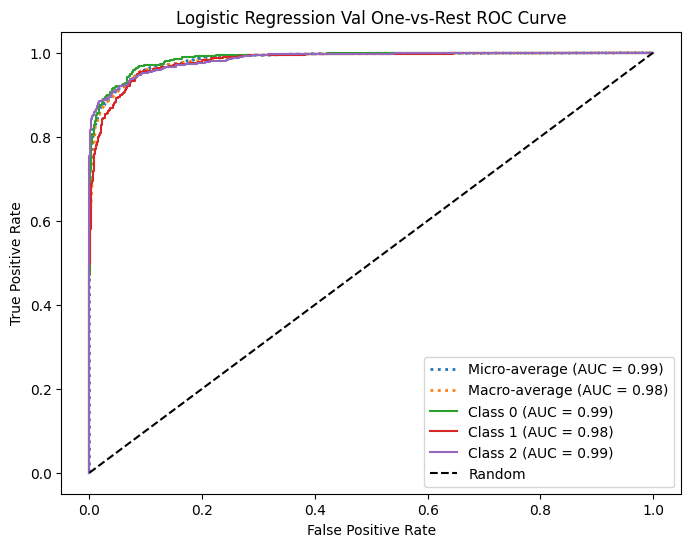


--------------------------------------------------

Testing
Logistic Regression Accuracy: 0.92
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       366
           1       0.90      0.91      0.91       303
           2       0.93      0.93      0.93       513

    accuracy                           0.92      1182
   macro avg       0.92      0.92      0.92      1182
weighted avg       0.92      0.92      0.92      1182

Test Confusion Matrix:
[[337  10  19]
 [ 13 275  15]
 [ 18  19 476]]


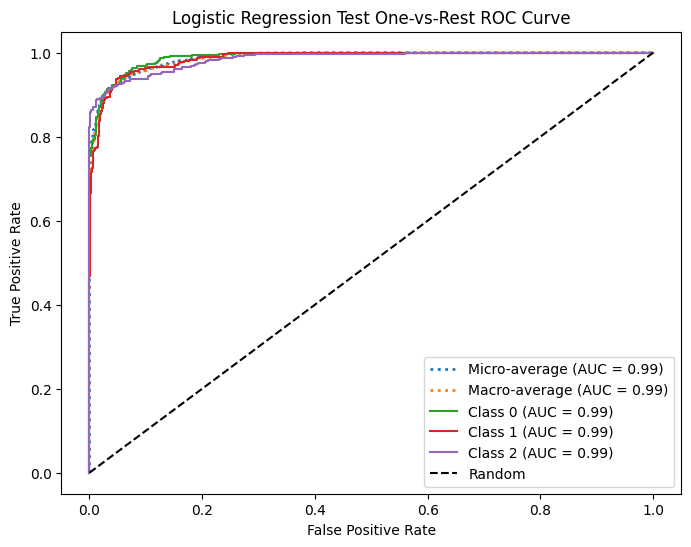




--------------------------------------------------
Shap:



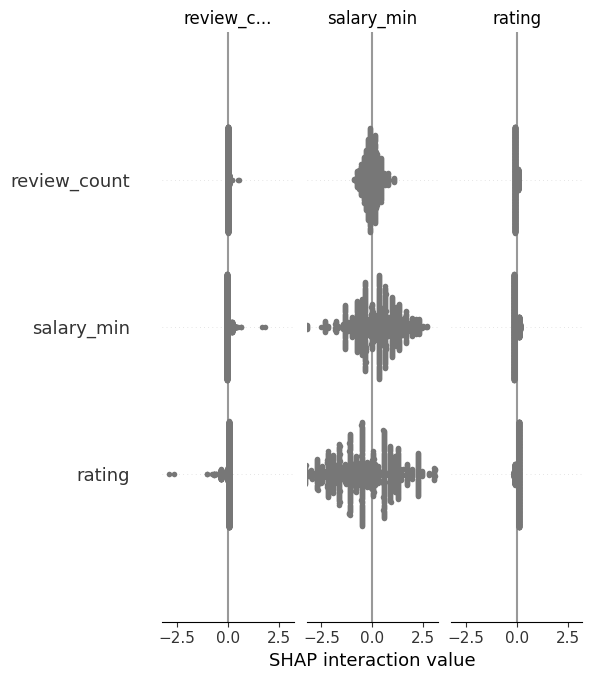

In [11]:
model = LogisticRegression(max_iter=1000, random_state=seed)
generate_report(model, "Logistic Regression", show_shap=True)

### SVM

SVM Cross-Validation Scores: [0.91779213 0.91661773 0.92307692 0.90951821 0.90658049]
SVM Cross-Validated Accuracy: 0.91 +/- 0.01

--------------------------------------------------

Validation
SVM Accuracy: 0.91
Val Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       623
           1       0.88      0.88      0.88       542
           2       0.94      0.92      0.93       964

    accuracy                           0.91      2129
   macro avg       0.91      0.91      0.91      2129
weighted avg       0.91      0.91      0.91      2129

Val Confusion Matrix:
[[577  20  26]
 [ 29 479  34]
 [ 27  47 890]]


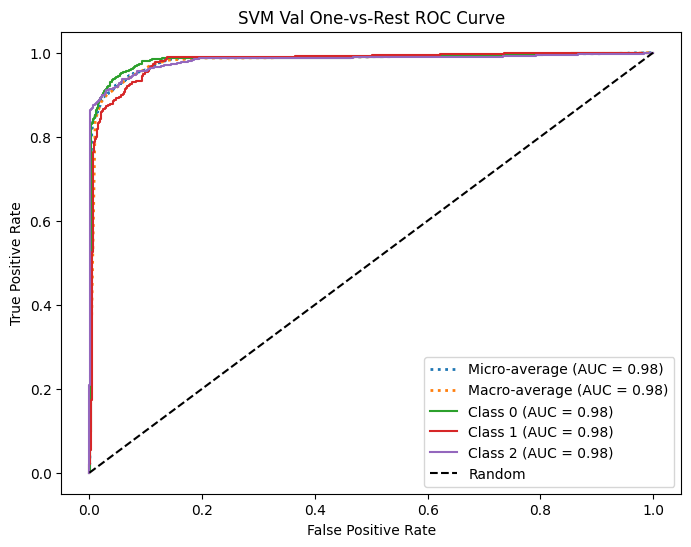


--------------------------------------------------

Testing
SVM Accuracy: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       366
           1       0.87      0.89      0.88       303
           2       0.94      0.91      0.93       513

    accuracy                           0.91      1182
   macro avg       0.91      0.91      0.91      1182
weighted avg       0.92      0.91      0.91      1182

Test Confusion Matrix:
[[341  13  12]
 [ 15 271  17]
 [ 18  26 469]]


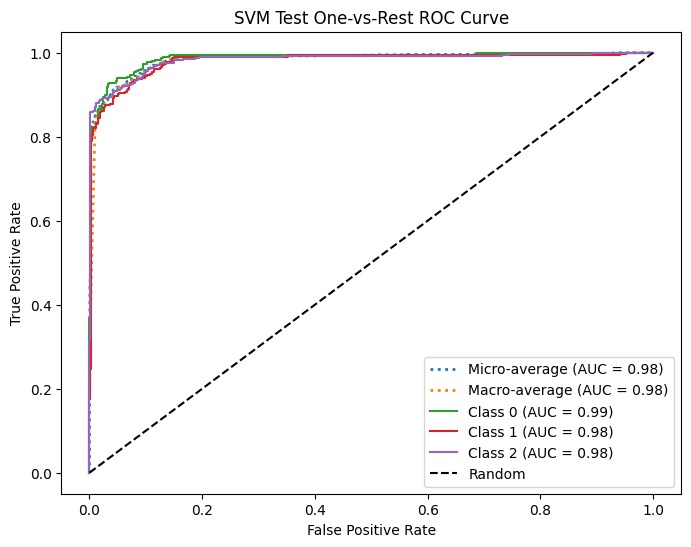

In [12]:
# model = SVC(C=10, probability=True, random_state=seed, decision_function_shape='ovr', kernel='rbf')
model = SVC(C=10, probability=True, random_state=seed, decision_function_shape='ovr', kernel='poly', gamma='scale',
            class_weight={0: class_weights[0], 1: class_weights[1], 2: class_weights[2]})

generate_report(model, "SVM")

### DecisionTreeClassifier

Decision Tree Cross-Validation Scores: [0.89900176 0.90487375 0.89724016 0.8907168  0.89189189]
Decision Tree Cross-Validated Accuracy: 0.90 +/- 0.01

--------------------------------------------------

Validation
Decision Tree Accuracy: 0.89
Val Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       623
           1       0.86      0.84      0.85       542
           2       0.91      0.91      0.91       964

    accuracy                           0.89      2129
   macro avg       0.88      0.88      0.88      2129
weighted avg       0.89      0.89      0.89      2129

Val Confusion Matrix:
[[554  31  38]
 [ 40 456  46]
 [ 45  43 876]]


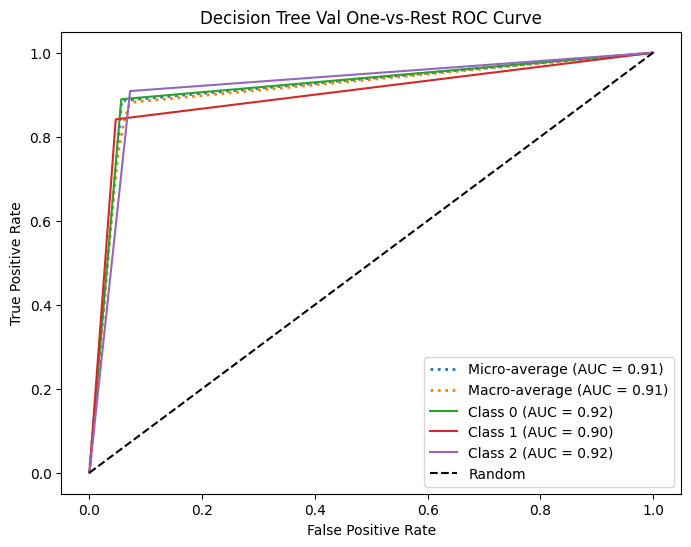


--------------------------------------------------

Testing
Decision Tree Accuracy: 0.90
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       366
           1       0.87      0.91      0.89       303
           2       0.93      0.91      0.92       513

    accuracy                           0.90      1182
   macro avg       0.90      0.90      0.90      1182
weighted avg       0.91      0.90      0.90      1182

Test Confusion Matrix:
[[327  16  23]
 [ 16 275  12]
 [ 20  26 467]]


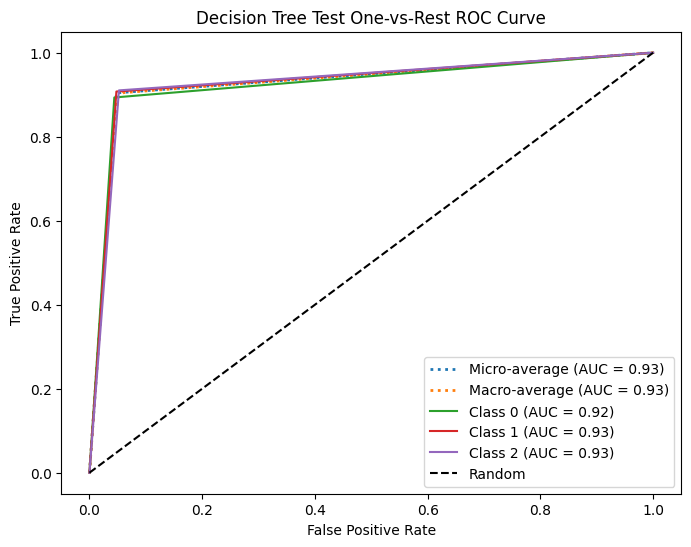

In [13]:
model = DecisionTreeClassifier(random_state=seed)
generate_report(model, "Decision Tree")

### RandomForestClassifier

Random Forest Cross-Validation Scores: [0.92425132 0.91661773 0.92190252 0.90951821 0.90364277]
Random Forest Cross-Validated Accuracy: 0.92 +/- 0.01

--------------------------------------------------

Validation
Random Forest Accuracy: 0.91
Val Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       623
           1       0.90      0.87      0.89       542
           2       0.94      0.91      0.93       964

    accuracy                           0.91      2129
   macro avg       0.91      0.91      0.91      2129
weighted avg       0.91      0.91      0.91      2129

Val Confusion Matrix:
[[587  11  25]
 [ 40 471  31]
 [ 43  39 882]]


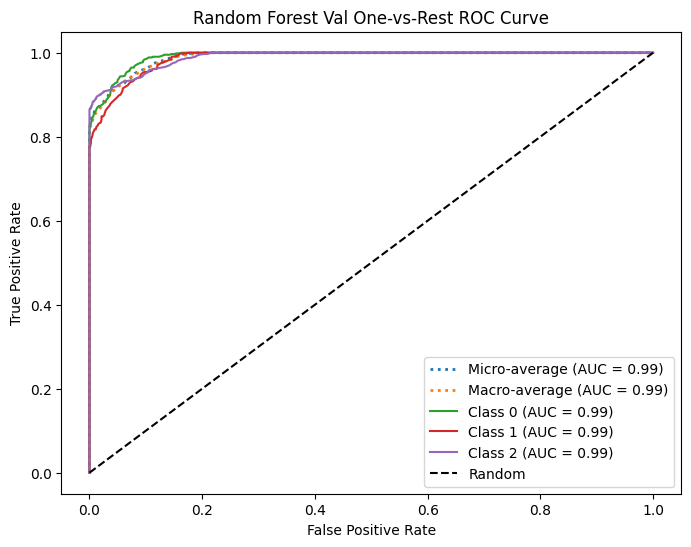


--------------------------------------------------

Testing
Random Forest Accuracy: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       366
           1       0.89      0.90      0.90       303
           2       0.94      0.91      0.93       513

    accuracy                           0.91      1182
   macro avg       0.91      0.91      0.91      1182
weighted avg       0.91      0.91      0.91      1182

Test Confusion Matrix:
[[336  11  19]
 [ 20 272  11]
 [ 24  21 468]]


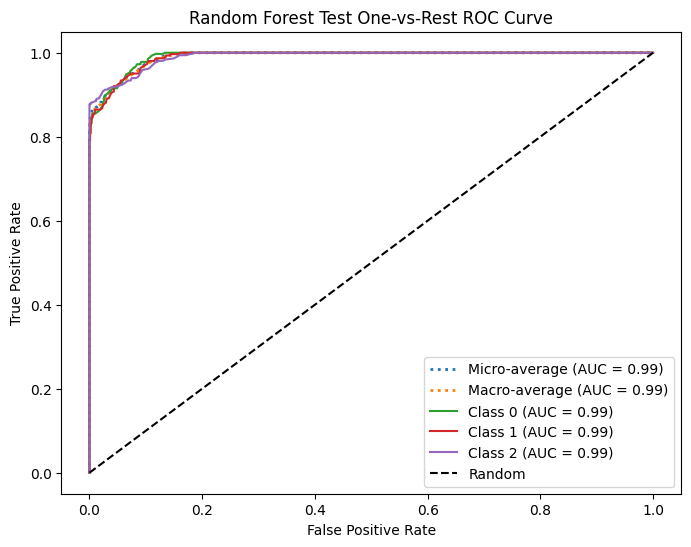

In [14]:
model = RandomForestClassifier(n_estimators=200, random_state=seed)
generate_report(model, "Random Forest")

In [15]:
# from sklearn.model_selection import GridSearchCV
# # Define the parameter grid to search
# param_grid = {
#     'classifier__C': [0.1, 1, 10],
#     'classifier__kernel': ['linear', 'rbf', 'poly'],
#     'classifier__gamma': ['scale', 'auto']
# }

# grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)

# # Fit the model with the best hyperparameters on the entire training set
# clf = grid_search.best_estimator_